In [1]:
'''
Importação do repositório
'''
!git clone https://github.com/teodororo/rna-atividade-avaliativa.git

Cloning into 'rna-atividade-avaliativa'...
remote: Enumerating objects: 2469, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 2469 (delta 3), reused 4 (delta 1), pack-reused 2459
Receiving objects: 100% (2469/2469), 59.67 MiB | 31.58 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Updating files: 100% (7009/7009), done.


In [4]:
'''
Importação de bibliotecas
'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input as convnex_preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB7,preprocess_input as b7_preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from itertools import islice
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
'''
Variaveis constantes
'''
TEST_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/test/'
TRAIN_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/train/'
VAL_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/validation/'
num_classes = 15
img_size = (224,224)

'''
Hiperparâmetros 
'''
batch_size = 6 # preferencialmente um multiplo de 2
weights = 'imagenet' # pode ser None (pesos aleatórios)
trainable_layers = False # se for True, ele ajusta tudo
epocas = 32

'''
Hiperparâmetros da camada extra do output
'''
_optimizer = keras.optimizers.SGD(lr=0.01)
_activation = 'softmax'

In [50]:
'''
Função de pre-processamento
'''
import cv2

def one_channel_to_three_channel(method):
    aux = np.zeros((method.shape[0],method.shape[1],3),dtype=np.uint8)
    aux[:,:,0] = method[:,:]
    aux[:,:,1] = method[:,:]
    aux[:,:,2] = method[:,:]

    return aux

def morphological_sobel(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobelX = np.uint8(np.absolute(sobelX))
    sobelY = np.uint8(np.absolute(sobelY))
    sobel = cv2.bitwise_or(sobelX, sobelY)

    return one_channel_to_three_channel(sobel)

def morphological_histogram(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(img.astype(np.uint8)) 

    return one_channel_to_three_channel(img) 

In [51]:
'''
Ajuste da base de dados
'''

train_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)
val_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)
test_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        VAL_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))

Found 1648 images belonging to 15 classes.
Found 239 images belonging to 15 classes.
Found 448 images belonging to 15 classes.
Classes: ['Black Widow', 'Blue Tarantula', 'Bold Jumper', 'Brown Grass Spider', 'Brown Recluse Spider', 'Deinopis Spider', 'Golden Orb Weaver', 'Hobo Spider', 'Huntsman Spider', 'Ladybird Mimic Spider', 'Peacock Spider', 'Red Knee Tarantula', 'Spiny-backed Orb-weaver', 'White Kneed Tarantula', 'Yellow Garden Spider']


In [52]:
def create_model():
    base_model = ConvNeXtTiny(
        input_shape=img_size + (3,),
        include_top=False,
        weights=weights
    )
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation=_activation)
    ])

    return model

model = create_model()
model.compile(
    optimizer=_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
checkpoint = ModelCheckpoint(
    'best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epocas,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint,earlyStopping]
)

Epoch 1/32
275/275 [==============================] - ETA: 0s - loss: 1.5924 - accuracy: 0.5018
Epoch 1: val_accuracy improved from -inf to 0.59833, saving model to best_weights.h5
275/275 [==============================] - 29s 75ms/step - loss: 1.5924 - accuracy: 0.5018 - val_loss: 1.1505 - val_accuracy: 0.5983
Epoch 2/32
274/275 [============================>.] - ETA: 0s - loss: 0.9100 - accuracy: 0.7132
Epoch 2: val_accuracy improved from 0.59833 to 0.69038, saving model to best_weights.h5
275/275 [==============================] - 15s 56ms/step - loss: 0.9089 - accuracy: 0.7136 - val_loss: 0.9167 - val_accuracy: 0.6904
Epoch 3/32
275/275 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.7603
Epoch 3: val_accuracy improved from 0.69038 to 0.75314, saving model to best_weights.h5
275/275 [==============================] - 16s 58ms/step - loss: 0.7445 - accuracy: 0.7603 - val_loss: 0.7647 - val_accuracy: 0.7531
Epoch 4/32
275/275 [==============================] 

In [54]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Test loss: 0.5222688913345337
Test accuracy: 0.828125


In [55]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=0)
print(report)

75/75 [==============================] - 5s 46ms/step
                         precision    recall  f1-score   support

            Black Widow       0.92      0.96      0.94        25
         Blue Tarantula       0.93      0.87      0.90        30
            Bold Jumper       0.87      0.95      0.91        43
     Brown Grass Spider       0.67      0.43      0.52        28
   Brown Recluse Spider       0.54      0.77      0.63        26
        Deinopis Spider       1.00      0.90      0.95        31
      Golden Orb Weaver       0.90      0.95      0.92        39
            Hobo Spider       0.56      0.50      0.53        30
        Huntsman Spider       0.76      0.78      0.77        36
  Ladybird Mimic Spider       0.94      0.80      0.86        20
         Peacock Spider       0.91      0.97      0.94        31
     Red Knee Tarantula       0.70      0.94      0.80        17
Spiny-backed Orb-weaver       0.91      0.97      0.94        33
  White Kneed Tarantula       0.79 

In [12]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Classification Report
                         precision    recall  f1-score   support

            Black Widow       0.96      0.96      0.96        25
         Blue Tarantula       0.94      0.97      0.95        30
            Bold Jumper       0.96      1.00      0.98        43
     Brown Grass Spider       0.78      0.50      0.61        28
   Brown Recluse Spider       0.67      0.77      0.71        26
        Deinopis Spider       1.00      1.00      1.00        31
      Golden Orb Weaver       0.90      0.95      0.92        39
            Hobo Spider       0.61      0.47      0.53        30
        Huntsman Spider       0.67      0.92      0.78        36
  Ladybird Mimic Spider       1.00      0.85      0.92        20
         Peacock Spider       1.00      1.00      1.00        31
     Red Knee Tarantula       1.00      1.00      1.00        17
Spiny-backed Orb-weaver       0.91      0.97      0.94        33
  White Kneed Tarantula       1.00      0.92      0.96        25
  

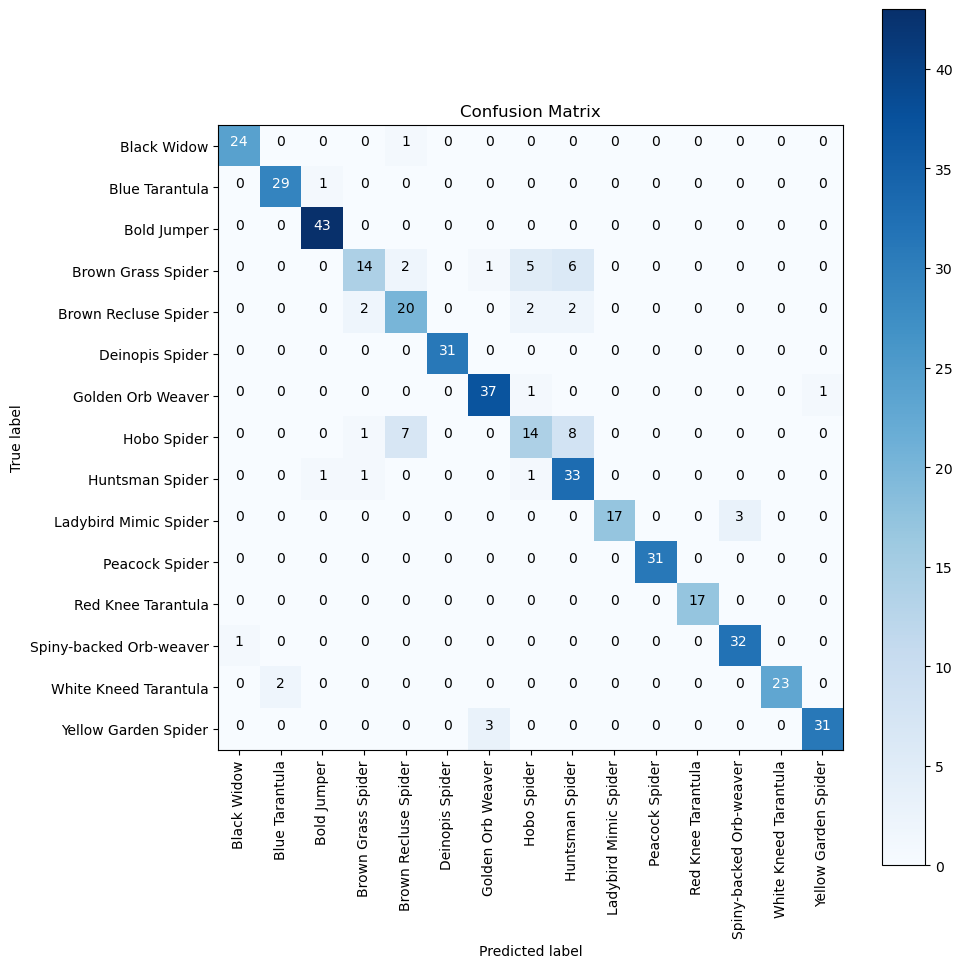

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

75/75 [==============================] - 3s 45ms/step


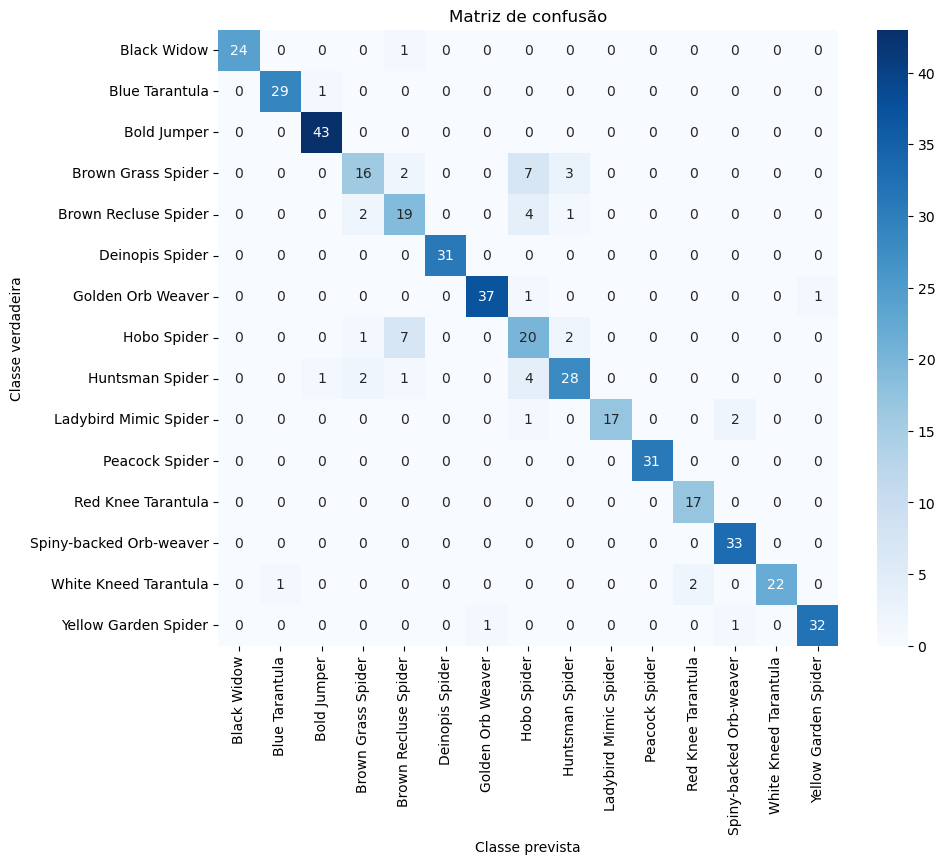

In [18]:
true_classes = test_generator.classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.title('Matriz de confusão')
plt.show()

In [4]:
'''
Resultados Convnext
'''

import pandas as pd

pd.DataFrame({
    'Otimizador'      :['Adam','Adam','Adam','Adam','SGD','SGD','SGD','SGD'],
    'Learning Rate'   :['0.001','0.0001','0.01','0.0001','0.001','0.0001','0.01','0.0001'],
    'Função Ativação' :['softmax','softmax','softmax','relu','softmax','softmax','softmax','relu'],
    'Acurácia'        :['0.8900','0.8800','0.8900','0.0600','0.8300','0.8500','0.8300','0.3300']
})

,Otimizador,Learning Rate,Função Ativação,Acurácia
0,Adam,0.001,softmax,0.8900
1,Adam,0.0001,softmax,0.8800
2,Adam,0.01,softmax,0.8900
3,Adam,0.0001,relu,0.0600
4,SGD,0.001,softmax,0.8300
5,SGD,0.0001,softmax,0.8500
6,SGD,0.01,softmax,0.8300
7,SGD,0.0001,relu,0.3300
